# Data Analytics Project
## Prediction and analysis of marital status of people in USA over the years

Authors: Julia Nowak, Adam Złocki

### 1. Problem Statement


##### Main problem
The goal of the project is to predict the number of adult married individuals in the U.S. society. The problem does not focus on specific races - general data common to all races has been accepted. However, the selected dataset allows for dividing the data into specific races and separate analysis of marital status. The idea of the project is based on the current topic concerning the hypothetical decline in the number of marriages and the increase in the number of divorces in highly developed countries such as the USA. During the analysis, we want to demonstrate existing trends and predict the distribution of the values we are interested in for the future.

##### Examples of use and reasons for analysis
The problem of predicting marital status and the number of marriages in society is extremely important information from the government's perspective. This is a problem worth analyzing, especially for planning the U.S. government's family policy. The topic is also significant for all types of estimates related to natural population growth or social conditions. The analysis can provide the government with early indications of certain changes occurring in society, which should be considered when creating future plans.

##### Data origin and content
The data we are using comes from the official U.S. government website (www.census.gov). It includes information on the number of people with a given marital status by year, the average age of first marriage, the number of households, and the overall average income per household member to present the general economic situation of the society.

Additionally, the data is available with a division by race, allowing for predictions for each race separately and subsequent comparative analysis, although we did not adopt this approach. The data we use is historical, spanning from the 20th century to 2023, with the latest update in November 2023, making it relatively recent. For the analysis, we used the years 1993-2023, excluding duplicates of some years (choosing the most recent data from each pair).

The data includes various tables from the Current Population Survey (CPS), conducted annually by the U.S. Census Bureau.

##### Data explanation
In our dataset we have six columns:
- Year - the year in which the data was collected,
- Married - number of people married in a given year (in thousands),
- Income per member - average income per household member in a given year,
- Mean age - the average age of entering into first marriage in a given year,
- Household - number of households in a given year,
- Total - total population (in thousands)

##### DAG Diagram
The following DAG diagram represents the dependencies utilized in our project. For our predictions, we applied average household income per member and the number of households, allowing us to examine the impact of the overall economic situation of society on the number of marriages. Additionally, we also took into account the average age of first marriage.


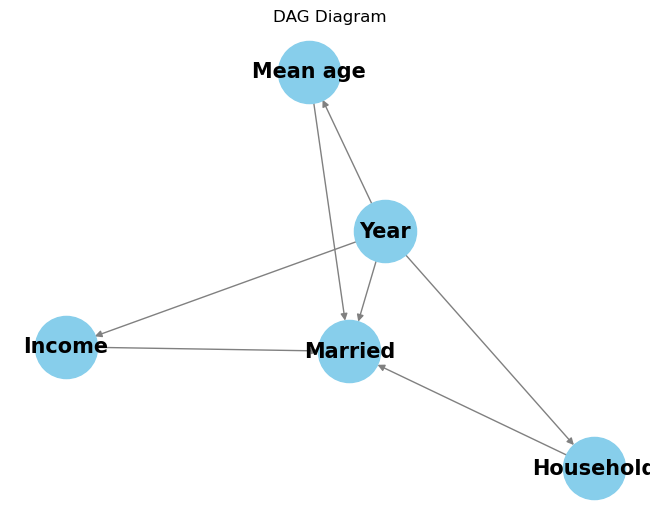

In [639]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Year")
G.add_node("Household")
G.add_node("Income")
G.add_node("Mean age")
G.add_node("Married")


# Add edges
G.add_edge("Year", "Household")
G.add_edge("Year", "Income")
G.add_edge("Year", "Mean age")
G.add_edge("Year", "Married")


G.add_edge("Income", "Married")
G.add_edge("Household", "Married")
G.add_edge("Mean age", "Married")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=15, font_weight='bold')

plt.title("DAG Diagram")
plt.show()


COLLIDERS - In a path that is an inverted fork (x -> m <- y), the node where two or more arrowheads meet is called a collider (because the paths collide there). An inverted fork is not an open path:

Household -> Married \
Mean age -> Married \
Income -> Married 



Fork: Example: A ← B ← C → D → E. Variable C forks into two chains, C → B → A and C → D → E.

FORKS: \
Year -> Mean age -> Married \
Year -> Household -> Married \
Year -> Income -> Married \
Year -> Married


The data can be represented differently based on the way of thinking. All our columns are higly correlated and it means that they all might have influence on each other.

### 2. Data Preprocessing

1. Selection of Analyzed Years and Races:

- Years 1993-2022 were chosen for analysis (almost 30 years of data).
- Years 2018-2023 were set aside for model evaluation.
- The focus was on analyzing overall data across all races combined.

2. Data Notes:

- In years 2011 and 2021, the data included duplicate results due to presenting both original and updated values based on the latest decennial population census (updated values were adopted).
- In 2014, there was a change in income-related survey questions, resulting in differences in questions asked to respondents.
- Since 2019, same-sex marriages have also been included.

3. Cleaning and Operations:

- Year format was changed from "..2011" to a format without dots.
- Year 2023 was excluded due to income data being from previous years.
- Duplicate years were removed.
- Data was merged to omit gender considerations.
- Total respondents were calculated (including data beyond the analyzed period).
- Household data was selected from a separate database for improved results.
- Years were transformed into numbers and data types were standardized.


##### Import necessary libraries

In [640]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import random

import warnings
import cmdstanpy
from cmdstanpy import CmdStanModel

import arviz as az
import scipy.stats as stats
# warnings.filterwarnings('ignore')

##### Reading data from a concatenated file

In [641]:
# Read from excel file
df_ac  = pd.read_excel("data.xlsx", sheet_name="Raw_data")

# Select only essential columns
df = df_ac[['Year', 'Married', 'Income per member', "Mean age", "Household"]]

##### Data splitting

In [642]:
# All data for testing purposes
df_all = df

# Selection of years - 5 years are left for checking results
df = df[:25]

# Quick look at the table
df.head()

,Year,Married,Income per member,Mean age,Household
0,1993,114601,15500,25.50,96391
1,1994,115253,16300,25.60,97107
2,1995,116554,16940,25.70,98990
3,1996,116561,17850,25.95,99627
4,1997,116752,18940,25.90,101018


##### Preliminary data analysis

In [643]:
# Data for models
df.describe()

,Year,Married,Income per member,Mean age,Household
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2005.000000,125517.720000,24412.000000,26.690000,112143.720000
std,7.359801,6685.028917,5173.445821,0.941962,9520.963469
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000
25%,1999.000000,119040.000000,21060.000000,25.950000,103874.000000
50%,2005.000000,127142.000000,24670.000000,26.350000,113343.000000
75%,2011.000000,130767.000000,27330.000000,27.400000,119927.000000
max,2017.000000,135749.000000,34640.000000,28.450000,126224.000000


In [644]:
# Data for checking purposes
df_all[25:].describe()

,Year,Married,Income per member,Mean age,Household
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2020.000000,136807.400000,39212.000000,29.120000,129012.400000
std,1.581139,922.352319,2530.784463,0.270647,1358.823866
min,2018.000000,135704.000000,35700.000000,28.800000,127586.000000
25%,2019.000000,136297.000000,38410.000000,28.900000,128451.000000
50%,2020.000000,136506.000000,38760.000000,29.150000,128579.000000
75%,2021.000000,137758.000000,40860.000000,29.300000,129244.000000
max,2022.000000,137772.000000,42330.000000,29.450000,131202.000000


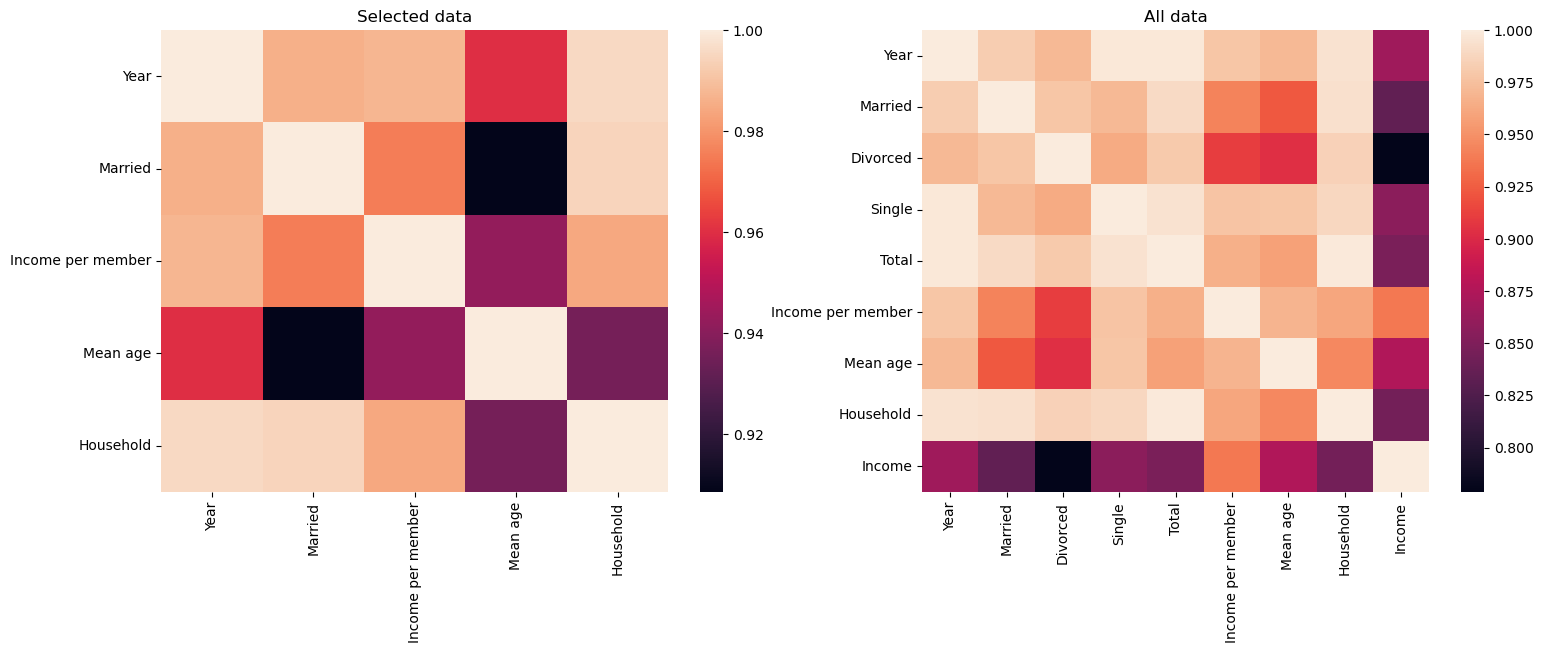

In [645]:
# Correlations

fig, ax = plt.subplots(1,2)

fig.set_size_inches(18, 6)

ax[0].set_title('Selected data')
sns.heatmap(df.corr(method="pearson"), ax=ax[0])

ax[1].set_title('All data')
sns.heatmap(df_ac.corr(method="pearson"), ax=ax[1])

plt.show()


##### Notice
The data we selected are strongly correlated with each other (over 90% correlation). High correlation typically means values in one column can be predicted from another, suggesting redundancy or collinearity. It is recommended to avoid having correlated features in your dataset. Indeed, a group of highly correlated features will not bring additional information (or just very few), but will increase the complexity of the algorithm, thus increasing the risk of errors.
Using highly correlated predictors in techniques like linear regression can result in highly unstable models, numerical errors, and very poor prediction performance.

However, since we are interested only in prediction and we don't want to make the assumptions about the relations within the data, we can use it to build our model.

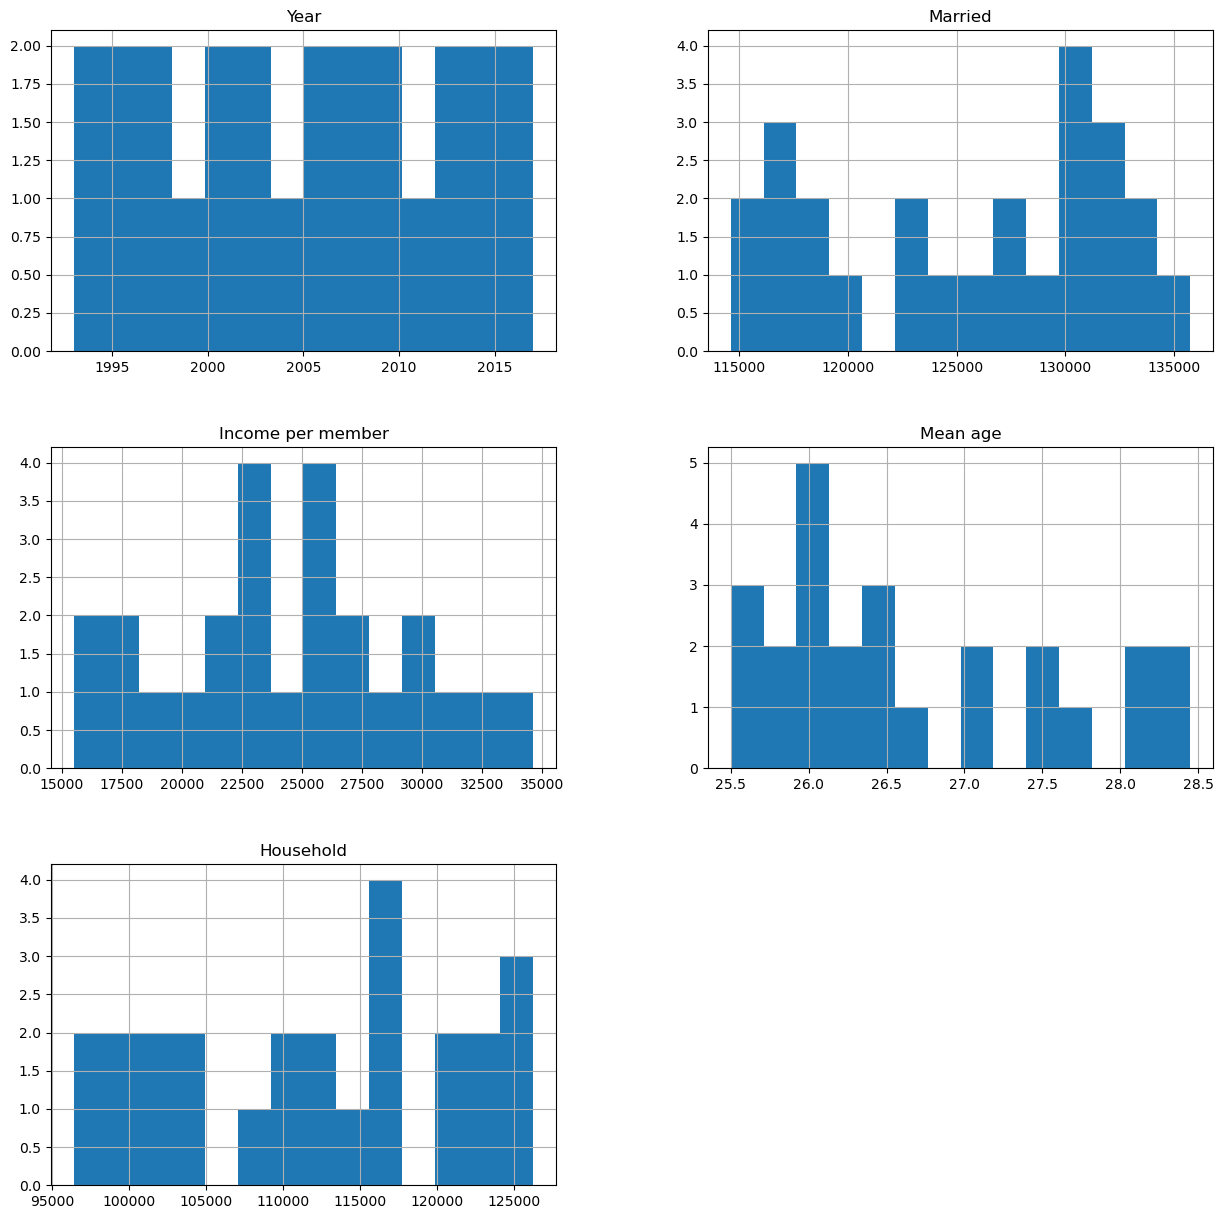

In [646]:
# Data overview
df.hist(figsize=(15,15), bins=14)
plt.show()

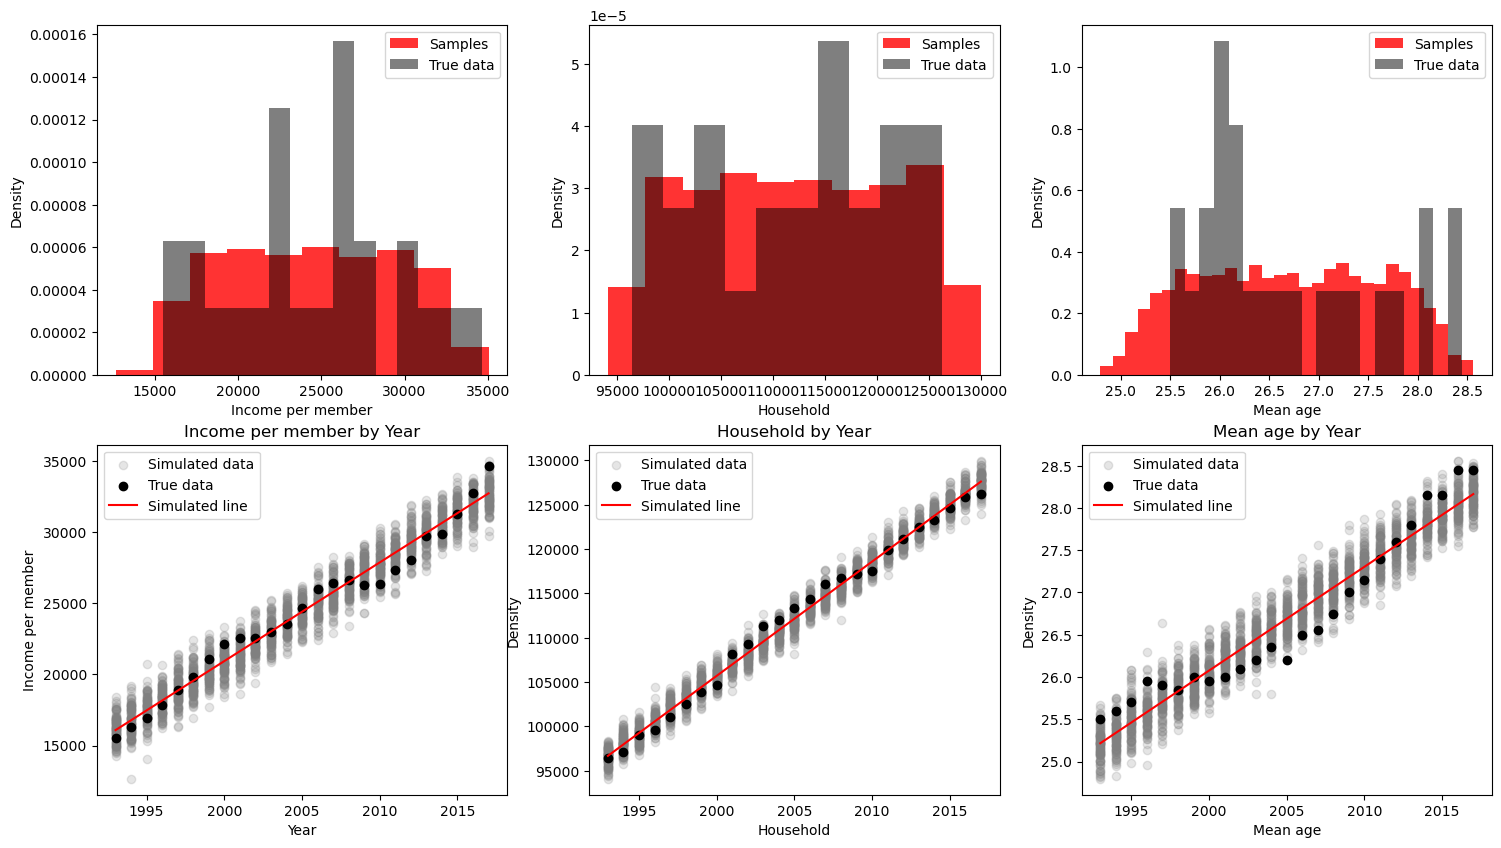

In [647]:
# Predictors - basic simulation

plt.figure(figsize=(18,10))
plt.subplot(2,3,1)

A = np.vstack([df['Year'], np.ones(len(df['Year']))]).T
a, b = np.linalg.lstsq(A, df['Income per member'], rcond=None)[0]

sim = random.normal(a*df['Year'] + b, 1000, (100, 25)) # mu, sigma, samples
# plt.plot(df['Income per member'], stats.norm.pdf(df['Income per member'], 25000, 4000), c='k')
plt.hist(sim.flatten().tolist(), color='red', alpha = 0.8, density=True, label="Samples")
plt.hist(df['Income per member'], color='black',bins=15, alpha = 0.5, density=True, label="True data")
plt.ylabel('Density')
plt.xlabel('Income per member')
plt.legend()

plt.subplot(2,3,4)
f1 = False
for i in sim:
    if not f1:
        plt.scatter(df['Year'], i, label="Simulated data", color='gray', alpha=0.2)
    else:    
        plt.scatter(df['Year'], i, color='gray', alpha=0.2)
    f1 = True
plt.scatter(df['Year'], df['Income per member'], label="True data", color='black')
plt.plot(df['Year'], a*df['Year']+ b, label="Simulated line", color='r')
plt.title('Income per member by Year')
plt.ylabel('Income per member')
plt.xlabel('Year')
plt.legend()

plt.subplot(2,3,2)
a, b = np.linalg.lstsq(A, df['Household'], rcond=None)[0]

sim = random.normal(a*df['Year'] + b, 1000, (100, 25)) # a - from, b - to, samples
# 1/(a-b) - height
# plt.plot(df['Household'], [1/(126000-96000)]*len(df['Household']), linewidth=2, color='k')
plt.hist(sim.flatten().tolist(), color='red', alpha = 0.8, density=True, label="Samples")
plt.hist(df['Household'], color='black',bins=10, alpha = 0.5, density=True, label="True data")
plt.ylabel('Density')
plt.xlabel('Household')
plt.legend()


plt.subplot(2,3,5)
f1 = False
for i in sim:
    if not f1:
        plt.scatter(df['Year'], i, label="Simulated data", color='gray', alpha=0.2)
    else:    
        plt.scatter(df['Year'], i, color='gray', alpha=0.2)
    f1 = True
plt.scatter(df['Year'], df['Household'], label="True data", color='black')
plt.plot(df['Year'], a*df['Year']+ b, label="Simulated line", color='r')

plt.title('Household by Year')
plt.ylabel('Density')
plt.xlabel('Household')
plt.legend()

plt.subplot(2,3,3)
a, b = np.linalg.lstsq(A, df['Mean age'], rcond=None)[0]
sim = random.normal(a*df['Year'] + b, 0.2, (100, 25))

plt.hist(sim.flatten().tolist(), color='red', alpha = 0.8, density=True, bins=30, label="Samples")
plt.hist(df['Mean age'], color='black', bins=20, alpha = 0.5, density=True, label="True data")
plt.ylabel('Density')
plt.xlabel('Mean age')
plt.legend()

plt.subplot(2,3,6)

f1 = False
for i in sim:
    if not f1:
        plt.scatter(df['Year'], i, label="Simulated data", color='gray', alpha=0.2)
    else:    
        plt.scatter(df['Year'], i, color='gray', alpha=0.2)
    f1 = True
plt.scatter(df['Year'], df['Mean age'], label="True data", color='black')
plt.plot(df['Year'], a*df['Year']+ b, label="Simulated line", color='r')
plt.title('Mean age by Year')
plt.ylabel('Density')
plt.xlabel('Mean age')
plt.legend()

plt.show()

### 3. Model creation

We have created two models: 
- the first model predicts the number of individuals after marriage based on data about average household income per member of the household, 
- the second model additionally utilizes the number of households and the average age of entering first marriage.

We incorporated additional information with the hope that expanding the context would improve the results and make them more reflective of reality.

Model I:

- Parameters:  $\alpha$, $\beta$, $\sigma$
- Data: Average household income per member
- Linear equation: f(income) = $\alpha$*income + $\beta$
- Sampling: y(income) = normal(f(income), $\sigma$)

Model II:

- Parameters: $\alpha_1$, $\alpha_2$, $\alpha_3$, $\beta$, $\sigma$
- Data: Average household income per member, number of households, average age of first marriage
- Linear equation: f(income, household, age) = $\alpha_1$*income + $\alpha_2$*household + $\alpha_3$*age + $\beta$
- Sampling: y(income) = normal(f(income, household, age), $\sigma$)




##### Differences
Despite highly correlated features, adding additional parameters makes sense as it complicates the equation but does not significantly impact the prediction. The impact is smaller, but the difference is noticeable.

In [648]:
# Creating models

N = 25
R = 100

model_1_prior = CmdStanModel(stan_file='prior.stan')
model_1_posterior = CmdStanModel(stan_file='posterior.stan')
model_2_prior = CmdStanModel(stan_file='tri_prior.stan')
model_2_posterior = CmdStanModel(stan_file='tri_posterior.stan')

### 4. Priors

##### Selection of priors for parameters

In the problem we are considering, determining priors for the parameters was based on several stages. We started by creating graphs and analyzing the data. Then, looking at how the data is distributed, we decided to choose functions that represent our problem for both models.

For the first model, we decided to use a linear function that depends on income. For the second model, we used multiple linear regression that depends on income, the number of households and mean age. In both cases, we used normal distribution for sampling and for the distribution of parameters.

After establishing the equations, it was necessary to select the appropriate ranges for the parameters. To determine the best fit, the "linalg.lstsq" function was used, which helped in choosing the parameters that best matched the course of our data. With these values in hand, the only remaining task was to determine the range within which these parameters could vary to yield meaningful results. This information was obtained by determining the lower and upper bounds of the parameter distribution and the results of the equations.


We have chosen following priors for our models:
- For model 1.:
    * $\alpha$ ∼ normal(1.26, 0.04), 
    * $\beta$ ∼ normal(94800, 2000), 

- For model 2.:
    * $\alpha_1$ ∼ normal(0.012, 0.001),
    * $\alpha_2$ ∼ normal(0.81, 0.01),
    * $\alpha_3$ ∼ normal(1280, 20), 
    * $\beta$ ∼ normal(68500, 2000),

#### 4.1. Model I

##### Parameters testing for Model I

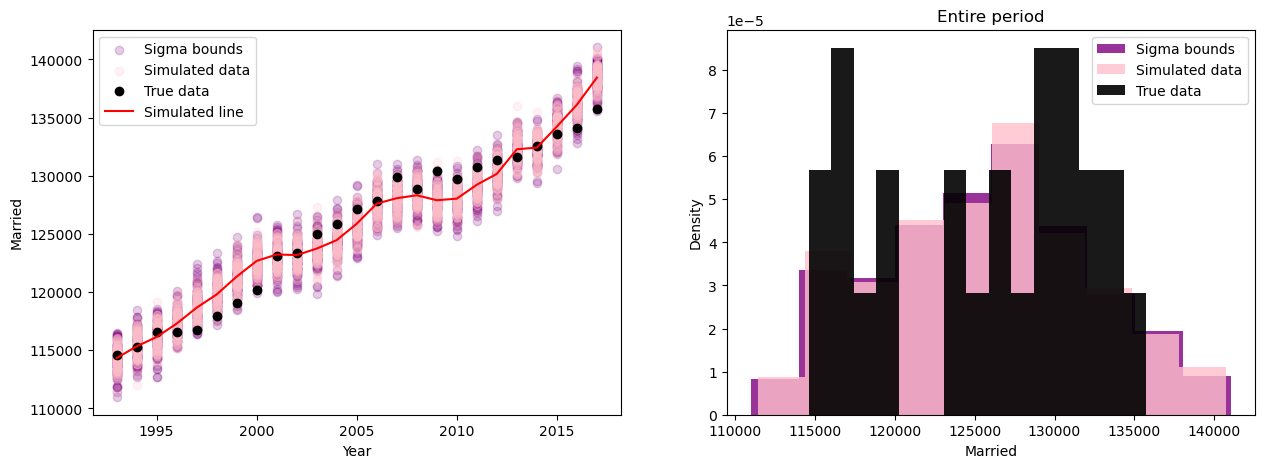

In [649]:
A = np.vstack([df['Income per member'], np.ones(len(df['Income per member']))]).T

# Parameter match - function modelling
a, b = np.linalg.lstsq(A, df['Married'], rcond=None)[0]

# Best selection of parameters
alpha = 1.26
beta = 94800
sigma = 1000

sim = random.normal(alpha*df['Income per member'] + beta, sigma, (100,25))
sim_sigma = random.normal(alpha*df['Income per member'] + beta, 1200, (100,25))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

f1 = False

for i in sim_sigma:
    if not f1:
        plt.scatter(df['Year'], i, color='purple', alpha=0.2, label="Sigma bounds")
    else:    
        plt.scatter(df['Year'], i, color='purple', alpha=0.2)
    f1 = True

f1 = False
for i in sim:
    if not f1:
        plt.scatter(df['Year'], i, label="Simulated data", color='pink', alpha=0.2)
    else:    
        plt.scatter(df['Year'], i, color='pink', alpha=0.2)
    f1 = True


plt.scatter(df['Year'], df['Married'], color='black', label="True data")
plt.plot(df['Year'], alpha*df['Income per member'] + beta, color='red', label="Simulated line")
plt.xlabel('Year')
plt.ylabel('Married')
plt.legend()


plt.subplot(1,2,2)
plt.hist(sim_sigma.flatten().tolist(), color='purple', alpha = 0.8, density=True, label="Sigma bounds")
plt.hist(sim.flatten().tolist(), color='pink', alpha = 0.8, density=True, label="Simulated data")

plt.hist(df['Married'], color='black',bins=15, alpha = 0.9, density=True, label="True data")
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()

plt.show()

##### Creating prior for Model I

In [650]:
# Setting data
data = {'N': N, 'income': df['Income per member']}

# creating prior for Model 1
prior_1 = model_1_prior.sample(
                    data=data,
                    iter_sampling=1000,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

04:09:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


04:09:08 - cmdstanpy - INFO - CmdStan done processing.


In [651]:
prior_1.draws_pd()

,lp__,accept_stat__,alpha,beta,sigma,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,1.39541,95965.8,745.546,117690.0,117675.0,119788.0,121768.0,124084.0,...,133310.0,132569.0,132863.0,134579.0,135800.0,137302.0,137705.0,138369.0,141794.0,143819.0
1,0.0,0.0,1.31904,94585.6,968.004,115649.0,116502.0,114183.0,119132.0,120076.0,...,129937.0,127898.0,128861.0,130372.0,132350.0,134103.0,134595.0,134711.0,137830.0,140274.0
2,0.0,0.0,1.32074,95939.3,1147.940,117763.0,118860.0,119220.0,120396.0,119079.0,...,129554.0,131458.0,132801.0,131651.0,130808.0,135657.0,135510.0,136200.0,140468.0,141663.0
3,0.0,0.0,1.27851,93917.6,1179.570,114282.0,113792.0,115394.0,114509.0,116955.0,...,126711.0,127386.0,129183.0,128770.0,129302.0,130610.0,130653.0,135606.0,135618.0,138016.0
4,0.0,0.0,1.29026,95390.9,1176.540,112888.0,116682.0,114596.0,117707.0,118797.0,...,128715.0,129807.0,130203.0,131228.0,130130.0,134945.0,134675.0,134490.0,138874.0,140176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,1.27123,98553.1,1036.820,118183.0,117229.0,119902.0,120342.0,122878.0,...,132858.0,133343.0,131705.0,131905.0,134866.0,135466.0,137084.0,137823.0,140610.0,142891.0
996,0.0,0.0,1.33231,93941.8,1039.430,114319.0,114919.0,117738.0,118057.0,119299.0,...,129874.0,128408.0,130151.0,130291.0,130731.0,132873.0,131173.0,134483.0,138201.0,139365.0
997,0.0,0.0,1.23141,95651.1,918.711,112691.0,115564.0,116900.0,117404.0,118547.0,...,128536.0,127824.0,126447.0,128034.0,129812.0,132311.0,132173.0,133365.0,134668.0,137519.0
998,0.0,0.0,1.37256,94020.4,1197.800,115393.0,116467.0,118045.0,117790.0,119128.0,...,130403.0,132019.0,130369.0,130344.0,135144.0,134933.0,132331.0,137190.0,140998.0,141160.0


##### Prior predictive checks for parameters of Model I

The simulated model parameters were checked after sampling. The obtained parameter values are consistent with the assumptions we made during their selection.

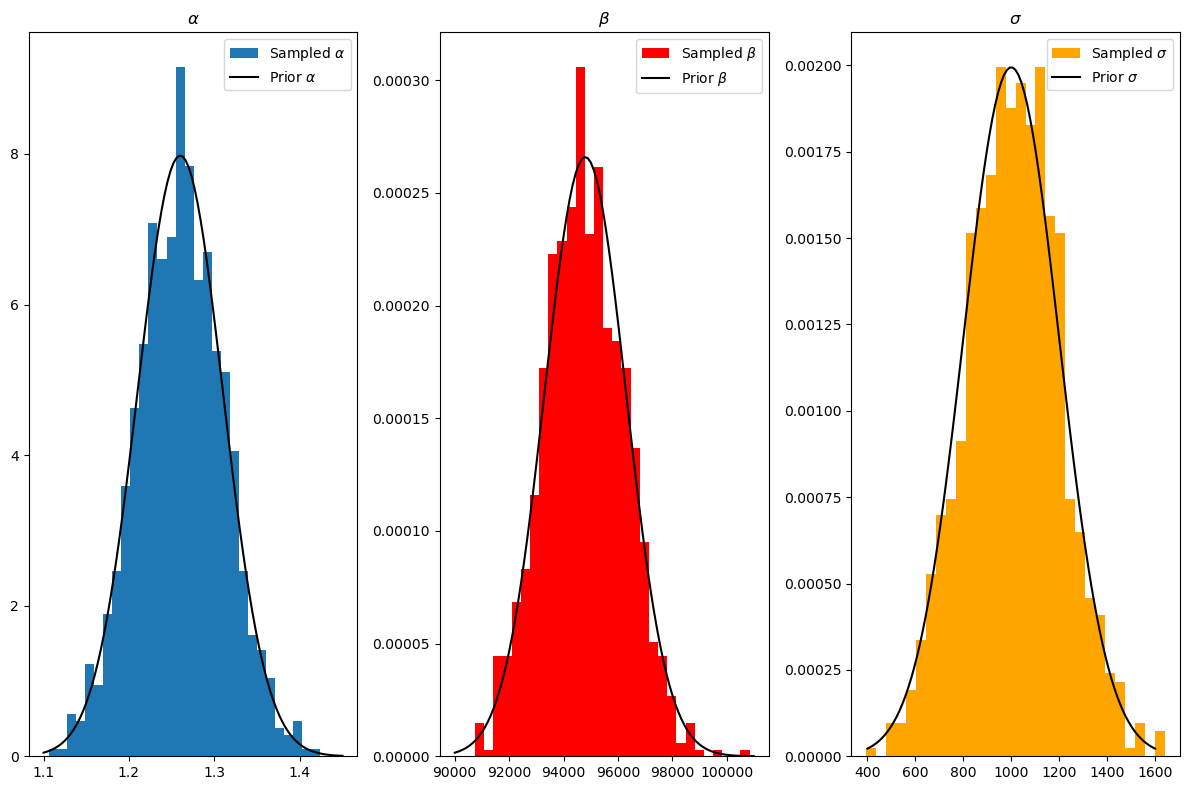

In [652]:
alpha_pred = prior_1.stan_variable('alpha')
beta_pred= prior_1.stan_variable('beta')
sigma_pred= prior_1.stan_variable('sigma')

fig,axes = plt.subplots(1,3,figsize = (12,8), tight_layout=True)
x = np.linspace(1.1,1.45,100)
y = stats.norm.pdf(x=x,loc=1.26, scale=0.05)
axes[0].hist(alpha_pred, bins=30,label=r'Sampled $\alpha$',density=True)
axes[0].set_title(r'$\alpha$')
axes[0].plot(x,y,label=r'Prior $\alpha$',color='k')
axes[0].legend()

x = np.linspace(90000, 101000, 100)
y = stats.norm.pdf(x=x,loc=94800, scale=1500)
axes[1].hist(beta_pred, bins=30,label=r'Sampled $\beta$',density=True,color='r')
axes[1].set_title(r'$\beta$')
axes[1].plot(x,y,label = r'Prior $\beta$',color='k')
axes[1].legend()

x = np.linspace(400, 1600, 100)
y = stats.norm.pdf(x=x,loc=1000, scale=200)
axes[2].hist(sigma_pred, bins=30,label=r'Sampled $\sigma$',density=True,color='orange')
axes[2].set_title(r'$\sigma$')
axes[2].plot(x,y,label = r'Prior $\sigma$',color='k')
axes[2].legend()

plt.show()

##### Prior predictive checks for measurements of Model I

We checked measurements for our prior predictive model and it is mostly correct. However, priors could have been chosen better, since the results are too much dispersed.

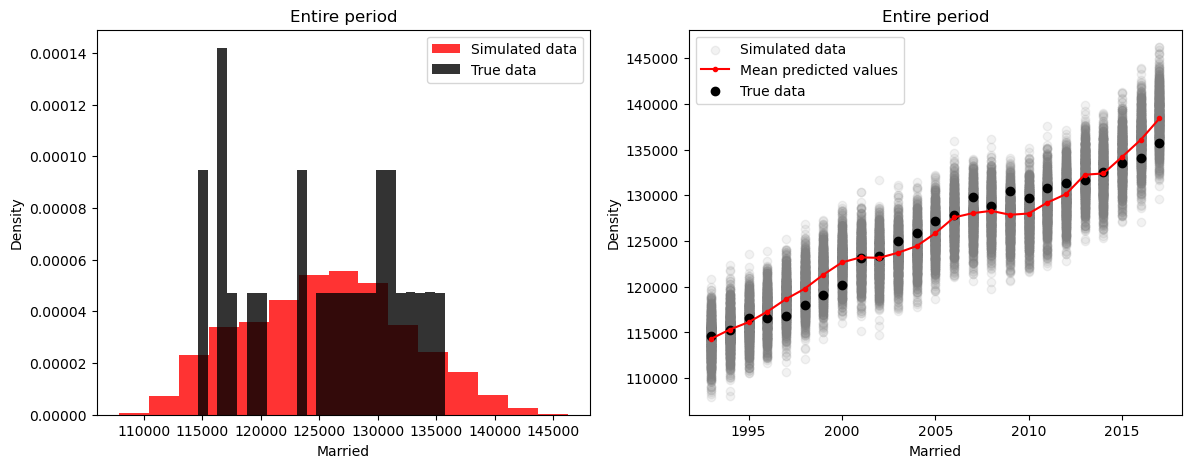

In [653]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(prior_1.y_sim.flatten().tolist(), bins=15, color='red', alpha = 0.8, density=True,label='Simulated data')
plt.hist(df['Married'], bins=25, color='black', alpha = 0.8, density=True,label='True data')
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()

plt.subplot(1,2,2)
flag = True
for i in prior_1.y_sim:
    if flag:
        plt.scatter(df['Year'], i, color='gray', alpha = 0.1,label='Simulated data')
        flag=False
    else:
        plt.scatter(df['Year'], i, color='gray', alpha = 0.1)


plt.plot(df['Year'], prior_1.alpha.mean()*df['Income per member'] + prior_1.beta.mean(), '.-' , color='r',label='Mean predicted values')
plt.scatter(df['Year'], df['Married'], color='k',label='True data')
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()

plt.show()

#### 4.2. Model II

##### Parameters testing for Model II

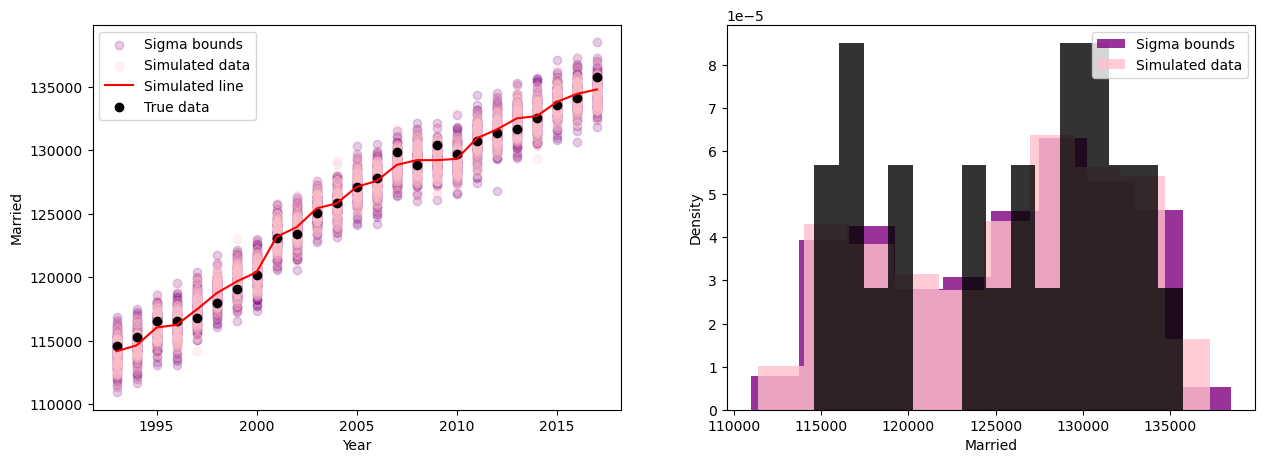

In [654]:

# Sample data
x = df['Income per member']
y = df['Household']
z = df['Mean age']

c = df['Married']

X = np.column_stack((np.ones_like(x), x, y, z))  # Add a column of ones for the intercept
coefficients = np.linalg.lstsq(X, c, rcond=None)[0]

# Extract coefficients
intercept, slope_x, slope_y, slope_z = coefficients

# Define points for the plane
z_plane = slope_x * x + slope_y * y + slope_z * z + intercept 


sim = random.normal(slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, sigma, (100,25))
sim_sigma = random.normal(slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, 1200, (100,25))


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
f1 = False

for i in sim_sigma:
    if not f1:
        plt.scatter(df['Year'], i, color='purple', alpha=0.2, label="Sigma bounds")
    else:    
        plt.scatter(df['Year'], i, color='purple', alpha=0.2)
    f1 = True

f1 = False
for i in sim:
    if not f1:
        plt.scatter(df['Year'], i, label="Simulated data", color='pink', alpha=0.2)
    else:    
        plt.scatter(df['Year'], i, color='pink', alpha=0.2)
    f1 = True


plt.plot(df['Year'], slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, color="red", label='Simulated line')
plt.scatter(df['Year'], df['Married'], color="k", label='True data')
plt.xlabel('Year')
plt.ylabel('Married')
plt.legend()

plt.subplot(1,2,2)

plt.hist(sim_sigma.flatten().tolist(), color='purple', alpha = 0.8, density=True, label="Sigma bounds")
plt.hist(sim.flatten().tolist(), color='pink', alpha = 0.8, density=True, label="Simulated data")

plt.legend()
plt.hist(df['Married'], color='black',bins=15, alpha = 0.8, density=True, label='True data')
plt.ylabel('Density')
plt.xlabel('Married')

plt.show()

##### Creating prior for Model II

In [655]:
# Setting data
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age']}

# creating prior for Model 1
prior_2 = model_2_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

04:09:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


04:09:19 - cmdstanpy - INFO - CmdStan done processing.


In [656]:
prior_2.draws_pd()

,lp__,accept_stat__,alpha_1,alpha_2,alpha_3,beta,sigma,y_sim[1],y_sim[2],y_sim[3],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,0.014708,0.817772,1254.55,68755.2,722.116,115996.0,117155.0,119349.0,...,131173.0,131557.0,131845.0,132684.0,133631.0,133227.0,134723.0,135315.0,137289.0,136692.0
1,0.0,0.0,0.011840,0.816388,1288.60,62824.4,1207.010,109475.0,110402.0,110206.0,...,124932.0,124353.0,124885.0,124300.0,126435.0,127323.0,128973.0,129549.0,130162.0,131044.0
2,0.0,0.0,0.013213,0.817903,1295.36,65232.6,1454.010,113323.0,110583.0,113856.0,...,126619.0,125082.0,128094.0,128156.0,129425.0,128919.0,131258.0,131757.0,130531.0,131852.0
3,0.0,0.0,0.010109,0.800013,1304.34,66800.5,941.695,111453.0,113778.0,112620.0,...,125429.0,125444.0,126256.0,127652.0,128784.0,126807.0,129178.0,127948.0,130108.0,130198.0
4,0.0,0.0,0.012259,0.794668,1259.70,70734.9,901.492,115086.0,114867.0,117004.0,...,130042.0,130488.0,131323.0,132082.0,131844.0,134415.0,133016.0,134608.0,135438.0,137204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.010789,0.799298,1277.12,66982.7,1123.800,112206.0,112555.0,115886.0,...,128169.0,126062.0,125239.0,129331.0,129394.0,129605.0,127908.0,130551.0,133034.0,131342.0
96,0.0,0.0,0.012588,0.813148,1287.05,69854.7,1295.280,115474.0,117558.0,118227.0,...,130942.0,132922.0,130600.0,132241.0,133835.0,133792.0,133068.0,135005.0,137189.0,136478.0
97,0.0,0.0,0.013253,0.812071,1244.70,68002.4,531.817,114488.0,115635.0,116018.0,...,129115.0,130413.0,130673.0,131541.0,131651.0,133427.0,133796.0,134785.0,134844.0,137050.0
98,0.0,0.0,0.011151,0.806342,1310.00,63997.8,1119.960,108177.0,107629.0,110917.0,...,122892.0,123134.0,124216.0,126861.0,128169.0,126764.0,127209.0,129798.0,129469.0,129428.0


##### Prior predictive checks for parameters of Model II

The simulated model parameters were checked after sampling. The obtained parameter values are consistent with the assumptions we made during their selection.


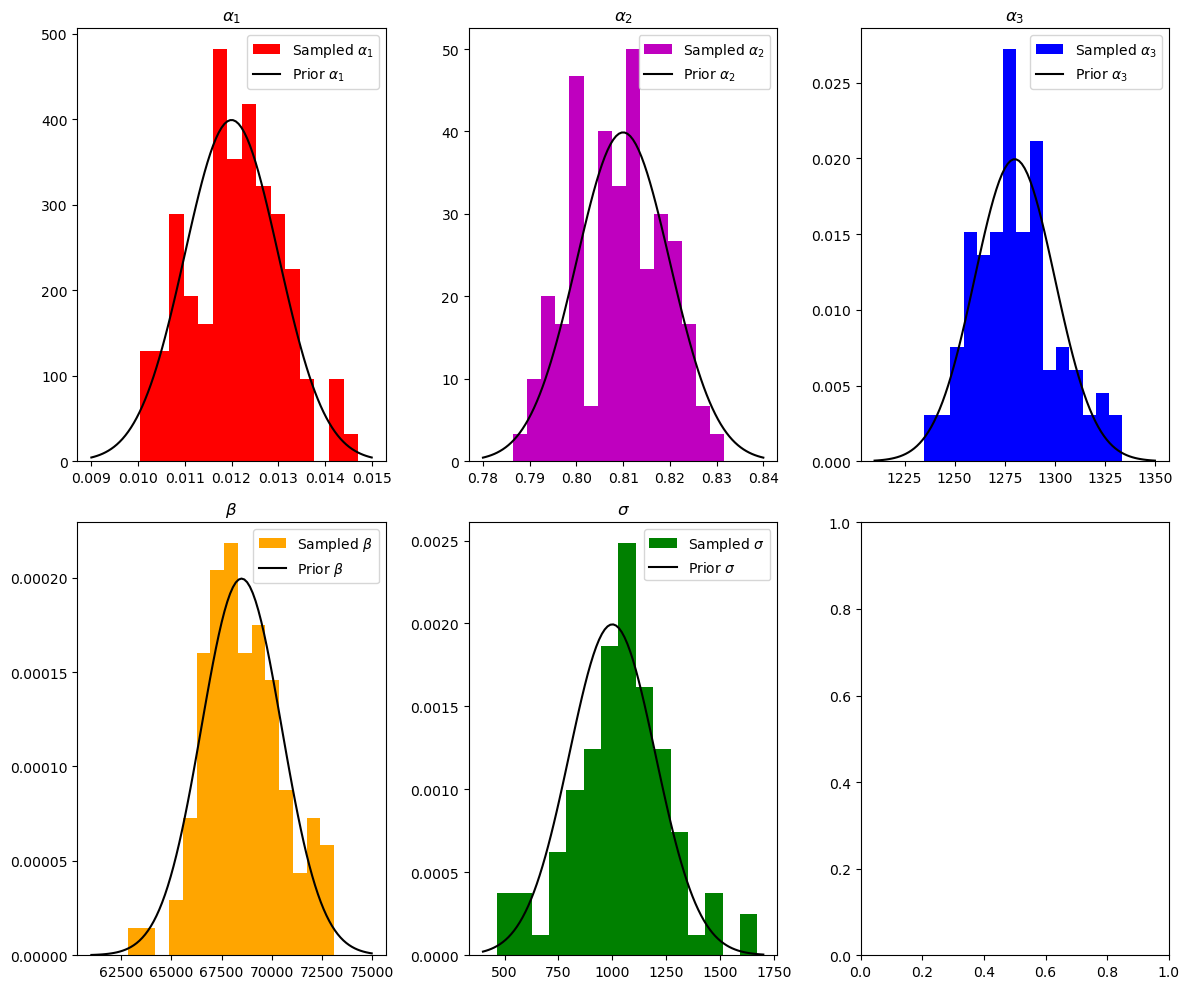

In [679]:
alpha1_pred = prior_2.stan_variable('alpha_1')
alpha2_pred = prior_2.stan_variable('alpha_2')
alpha3_pred = prior_2.stan_variable('alpha_3')
beta_pred= prior_2.stan_variable('beta')
sigma_pred= prior_2.stan_variable('sigma')

fig,axes = plt.subplots(2,3,figsize = (12,10), tight_layout=True)
x = np.linspace(0.009,0.015,100)
y = stats.norm.pdf(x=x,loc=0.012, scale=0.001)
axes[0][0].hist(alpha1_pred, bins=15,label=r'Sampled $\alpha_1$',density=True,color='r')
axes[0][0].set_title(r'$\alpha_1$')
axes[0][0].plot(x,y,label=r'Prior $\alpha_1$',color='k')
axes[0][0].legend()

x = np.linspace(0.78,0.84,100)
y = stats.norm.pdf(x=x,loc=0.81, scale=0.01)
axes[0][1].hist(alpha2_pred, bins=15,label=r'Sampled $\alpha_2$',density=True,color='m')
axes[0][1].set_title(r'$\alpha_2$')
axes[0][1].plot(x,y,label=r'Prior $\alpha_2$',color='k')
axes[0][1].legend()

x = np.linspace(1210,1350,100)
y = stats.norm.pdf(x=x,loc=1280, scale=20)
axes[0][2].hist(alpha3_pred, bins=15,label=r'Sampled $\alpha_3$',density=True,color='b')
axes[0][2].set_title(r'$\alpha_3$')
axes[0][2].plot(x,y,label=r'Prior $\alpha_3$',color='k')
axes[0][2].legend()

x = np.linspace(61000, 75000, 100)
y = stats.norm.pdf(x=x,loc=68500, scale=2000)
axes[1][0].hist(beta_pred, bins=15,label=r'Sampled $\beta$',density=True,color='orange')
axes[1][0].set_title(r'$\beta$')
axes[1][0].plot(x,y,label = r'Prior $\beta$',color='k')
axes[1][0].legend()

x = np.linspace(400, 1700, 100)
y = stats.norm.pdf(x=x,loc=1000, scale=200)
axes[1][1].hist(sigma_pred, bins=15,label=r'Sampled $\sigma$',density=True,color='g')
axes[1][1].set_title(r'$\sigma$')
axes[1][1].plot(x,y,label = r'Prior $\sigma$',color='k')
axes[1][1].legend()


plt.show()

##### Prior predictive checks for measurements of Model II

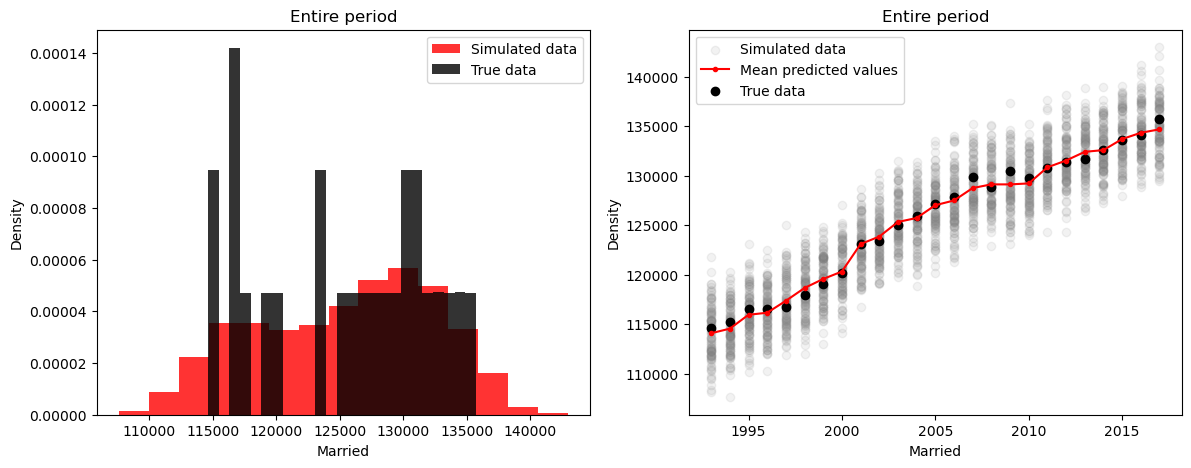

In [658]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(prior_2.y_sim.flatten().tolist(), bins=15, color='red', alpha = 0.8, density=True,label='Simulated data')
plt.hist(df['Married'], bins=25, color='black', alpha = 0.8, density=True,label='True data')
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()

plt.subplot(1,2,2)
flag = True
for i in prior_2.y_sim:
    if flag:
        plt.scatter(df['Year'], i, color='gray', alpha = 0.1,label='Simulated data')
        flag=False
    else:
        plt.scatter(df['Year'], i, color='gray', alpha = 0.1)


plt.plot(df['Year'], prior_2.alpha_1.mean()*df['Income per member'] + prior_2.alpha_2.mean()*df['Household'] - prior_2.alpha_3.mean()*df['Mean age'] + prior_2.beta.mean(), '.-' , color='r',label='Mean predicted values')
plt.scatter(df['Year'], df['Married'], color='k',label='True data')
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()

plt.show()

### 5. Posterior (model 1) - analysis

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]

No issues with sampling.

- are the samples from posterior predictive distribution analyzed [1 pt]


- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)


- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [659]:
data = {'N': N, 'income': df['Income per member'], 'y': df['Married']}
post_1 = model_1_posterior.sample(data=data, chains=1, iter_sampling=100)

04:09:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


04:09:22 - cmdstanpy - INFO - CmdStan done processing.


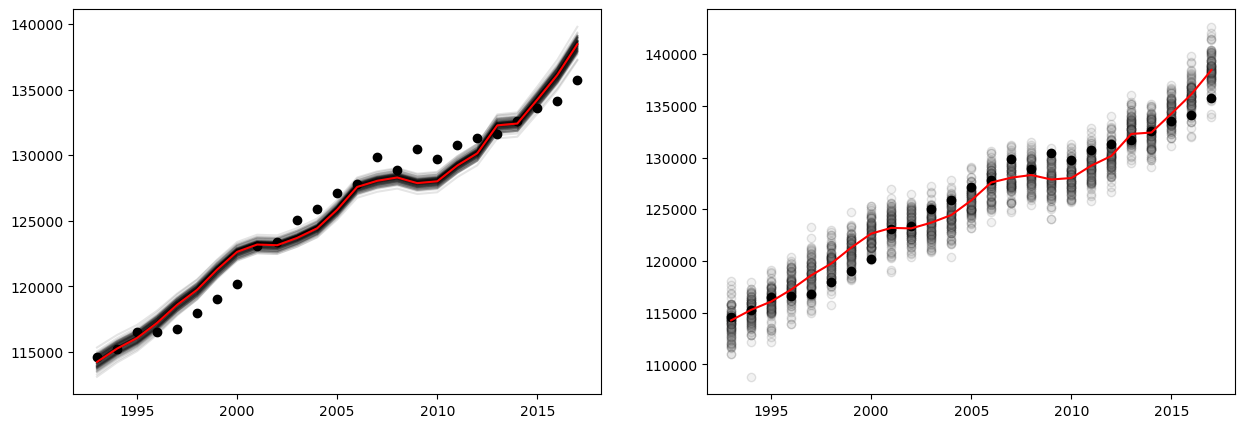

In [660]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(post_1.y_sim)):
    plt.plot(df['Year'], post_1.alpha[i]*df['Income per member'] + post_1.beta[i], color='black', alpha = 0.1)
plt.plot(df['Year'], post_1.alpha.mean()*df['Income per member'] + post_1.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_1.y_sim)):
    plt.scatter(df['Year'], post_1.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black")
plt.plot(df['Year'], post_1.alpha.mean()*df['Income per member'] + post_1.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.show()

In [661]:
post_1.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-190.52200,0.227602,1.406080,-193.95700,-190.01200,-189.24200,38.1654,2935.80,0.989963
alpha,1.26514,0.005907,0.033797,1.21638,1.26878,1.31621,32.7335,2517.96,0.992893
beta,94640.50000,138.515000,874.555000,93186.50000,94594.40000,95786.30000,39.8638,3066.45,0.991866
sigma,1284.73000,14.838600,115.645000,1114.66000,1284.05000,1471.39000,60.7388,4672.21,1.048940
y_sim[1],114055.00000,160.651000,1393.810000,111696.00000,114128.00000,116371.00000,75.2732,5790.24,0.991581
y_sim[2],115115.00000,123.381000,1320.240000,112865.00000,115205.00000,116954.00000,114.5010,8807.73,1.022380
y_sim[3],116017.00000,137.671000,1340.590000,113349.00000,116118.00000,118041.00000,94.8213,7293.94,1.011410
y_sim[4],117440.00000,149.331000,1290.560000,115089.00000,117405.00000,119459.00000,74.6896,5745.35,0.993863
y_sim[5],118568.00000,162.327000,1566.620000,115959.00000,118695.00000,121022.00000,93.1424,7164.80,1.036410
y_sim[6],119692.00000,115.472000,1379.210000,117536.00000,119823.00000,121963.00000,142.6610,10973.90,0.991389


### 6. Posterior (model 2) - analysis

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [662]:
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age'], 'y': df['Married']}
post_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=100)

04:09:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


04:09:24 - cmdstanpy - INFO - CmdStan done processing.


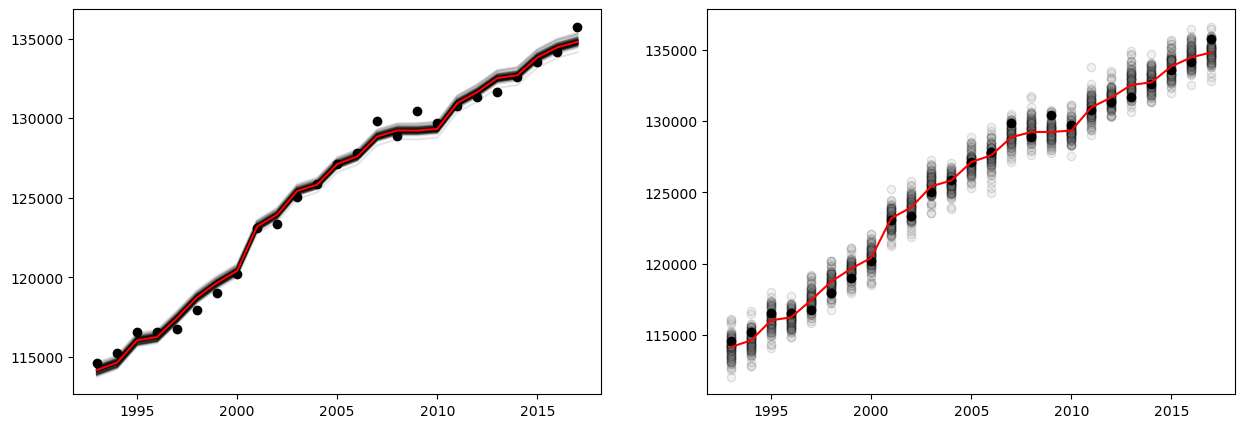

In [663]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(post_2.y_sim)):
    plt.plot(df['Year'], post_2.alpha_1[i]*df['Income per member'] + post_2.alpha_2[i]*df['Household'] - post_2.alpha_3[i]*df['Mean age'] + post_2.beta[i], color='black', alpha = 0.1)
plt.plot(df['Year'], post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_2.y_sim)):
    plt.scatter(df['Year'], post_2.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black")
plt.plot(df['Year'], post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.show()

In [664]:
post_2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-169.155000,0.495088,2.539020,-174.401000,-168.187000,-166.758000,26.3008,1252.42,1.046910
alpha_1,0.012053,0.000084,0.001193,0.009837,0.011968,0.014189,200.0000,9523.81,0.990295
alpha_2,0.809434,0.001115,0.008225,0.795254,0.809746,0.822499,54.4595,2593.31,1.013690
alpha_3,1272.320000,3.192990,22.938900,1229.120000,1270.670000,1308.960000,51.6118,2457.71,0.995180
beta,68414.300000,103.586000,846.072000,67068.400000,68448.000000,69704.200000,66.7128,3176.80,1.044760
sigma,690.867000,18.734700,108.044000,551.688000,672.152000,902.166000,33.2591,1583.77,1.050720
y_sim[1],114157.000000,73.525700,745.240000,112989.000000,114194.000000,115255.000000,102.7340,4892.09,0.992238
y_sim[2],114652.000000,72.205100,695.198000,113515.000000,114684.000000,115636.000000,92.7005,4414.31,0.992508
y_sim[3],116131.000000,74.375800,733.207000,114972.000000,116091.000000,117308.000000,97.1828,4627.75,1.008610
y_sim[4],116185.000000,62.315000,565.102000,115269.000000,116157.000000,117127.000000,82.2372,3916.06,1.037460


### 7. Model comparison

- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]

The WAIC and LOO (information criteria) were used for model comparison, and both indicated that the more complex model achieves better results, which is also consistent with the level of fit of the plotted graph over the entire data range. However, if we consider only the subset of data that was not included in the model fitting process, the less complex model performs better.

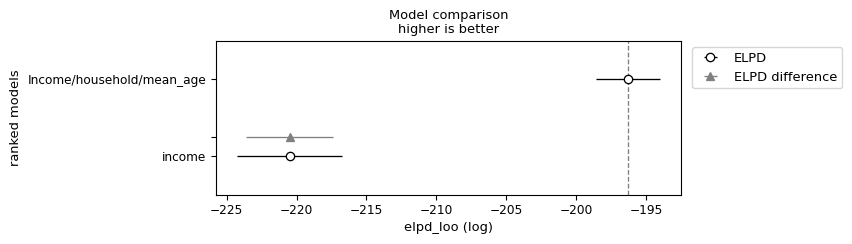

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Income/household/mean_age,0,-196.303771,1.543467,0.000000,1.0,2.287219,0.000000,False,log
income,1,-220.490578,2.630141,24.186807,0.0,3.755277,3.118627,False,log


In [665]:
# Compare the models using LOO
loo_compare = az.compare({"income": post_1, "Income/household/mean_age": post_2}, ic="loo")

az.plot_compare(loo_compare)
plt.show()
loo_compare

In [666]:
az.loo(post_1)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -220.49     3.76
p_loo        2.63        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       24   96.0%
 (0.5, 0.7]   (ok)          1    4.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [667]:
az.loo(post_2)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -196.30     2.29
p_loo        1.54        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       23   92.0%
 (0.5, 0.7]   (ok)          2    8.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

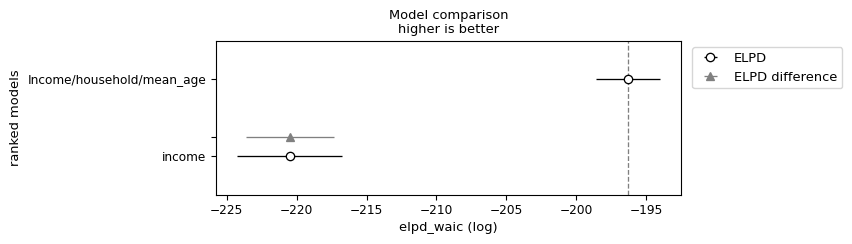

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Income/household/mean_age,0,-196.293033,1.532729,0.000000,1.0,2.289753,0.000000,False,log
income,1,-220.492428,2.631991,24.199395,0.0,3.767787,3.131343,True,log


In [668]:
# Compare the models using WAIC
waic_compare = az.compare({"income": post_1, "Income/household/mean_age": post_2}, ic="waic")

az.plot_compare(waic_compare)
plt.show()
waic_compare

In [669]:
az.waic(post_1)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -220.49     3.77
p_waic        2.63        -

There has been a warning during the calculation. Please check the results.

In [670]:
az.waic(post_2)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -196.29     2.29
p_waic        1.53        -

For both criteria, the more complex model achieved a higher score, so it can be considered better than the simpler one.

In [671]:
data = {'N': 5, 'income': df_all['Income per member'][25:], 'y': df_all['Married'][25:]}
post_test_1 = model_1_posterior.sample(data=data, chains=1, iter_sampling=R)

data = {'N': 5, 'income': df_all['Income per member'][25:], 'household': df_all['Household'][25:], 'mean_age': df_all['Mean age'][25:], 'y': df_all['Married'][25:]}
post_test_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=R)

04:09:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


04:09:27 - cmdstanpy - INFO - CmdStan done processing.
04:09:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed                     


04:09:28 - cmdstanpy - INFO - CmdStan done processing.


In [672]:
post_test_2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-35.087000,0.335548,1.672170,-38.405100,-34.810000,-32.957400,24.8343,1552.140,0.999706
alpha_1,0.012034,0.000109,0.001152,0.010071,0.012041,0.013504,111.8960,6993.490,1.002560
alpha_2,0.811488,0.001791,0.009241,0.795917,0.812868,0.825355,26.6187,1663.670,1.071930
alpha_3,1278.950000,1.979700,20.788500,1244.110000,1276.610000,1312.200000,110.2680,6891.750,0.998543
beta,68909.800000,332.425000,1319.100000,66453.100000,69085.400000,70808.500000,15.7458,984.115,1.133980
sigma,1170.390000,28.833800,156.164000,880.142000,1159.490000,1443.180000,29.3333,1833.330,1.036910
y_sim[1],135951.000000,127.608000,1212.680000,133824.000000,136141.000000,137703.000000,90.3101,5644.380,1.009330
y_sim[2],136880.000000,131.192000,1216.600000,134872.000000,136850.000000,138567.000000,85.9965,5374.780,1.018470
y_sim[3],135944.000000,154.070000,1502.180000,133326.000000,135947.000000,138276.000000,95.0618,5941.360,1.010200
y_sim[4],136756.000000,147.356000,1358.690000,134647.000000,136627.000000,139080.000000,85.0163,5313.520,0.990179


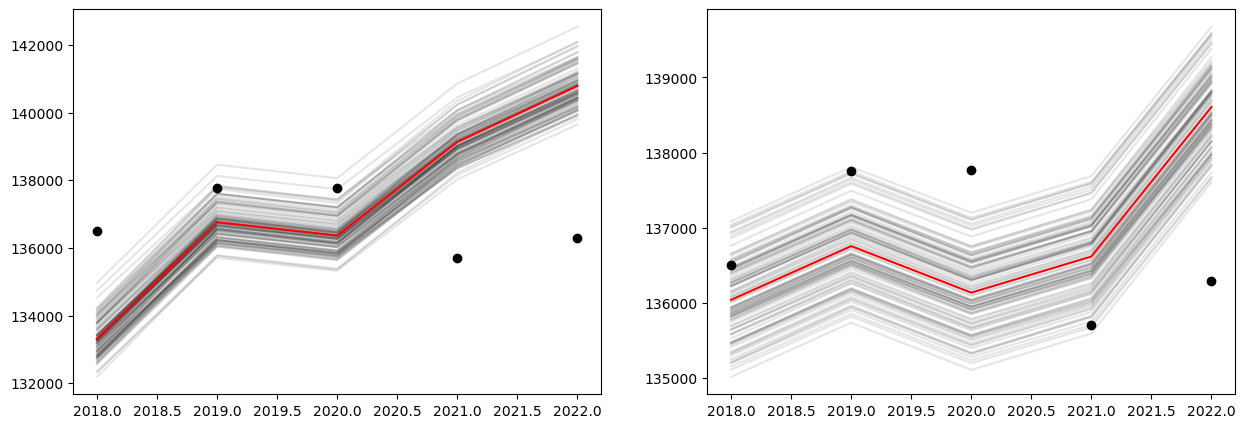

In [673]:
plt.figure(figsize=(15,5))

df_whole = df_all
df_all = df_all[25:]
plt.subplot(1,2,1)
for i in range(len(post_test_1.y_sim)):
    plt.plot(df_all['Year'], post_test_1.alpha[i]*df_all['Income per member'] + post_test_1.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_1.alpha.mean()*df_all['Income per member'] + post_test_1.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_test_2.y_sim)):
    plt.plot(df_all['Year'], post_test_2.alpha_1[i]*df_all['Income per member'] + post_test_2.alpha_2[i]*df_all['Household'] - post_test_2.alpha_3[i]*df_all['Mean age'] + post_test_2.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_2.alpha_1.mean()*df_all['Income per member'] + post_test_2.alpha_2.mean()*df_all['Household'] - post_test_2.alpha_3.mean()*df_all['Mean age'] + post_test_2.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()

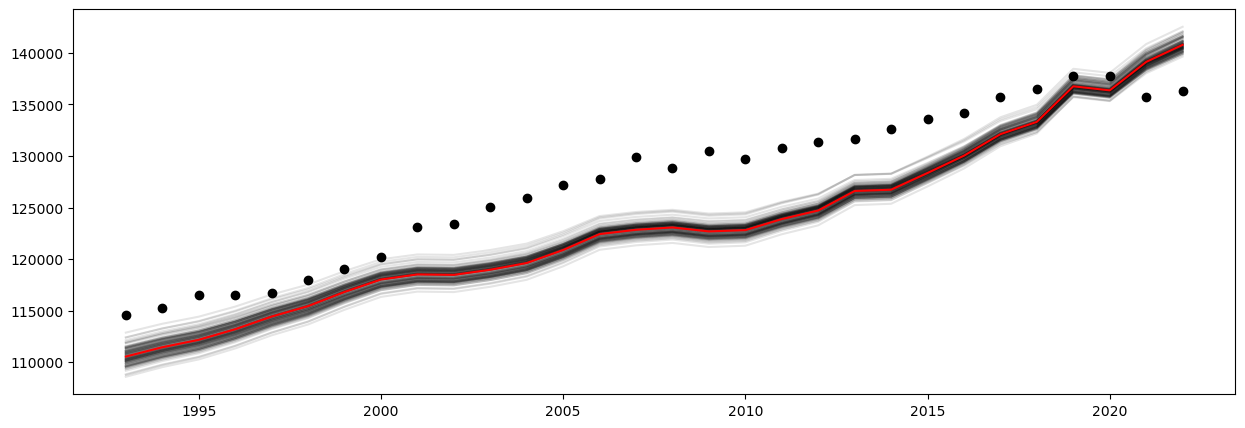

In [674]:
plt.figure(figsize=(15,5))

df_all = df_whole
for i in range(len(post_test_1.y_sim)):
    plt.plot(df_all['Year'], post_test_1.alpha[i]*df_all['Income per member'] + post_test_1.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_1.alpha.mean()*df_all['Income per member'] + post_test_1.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()

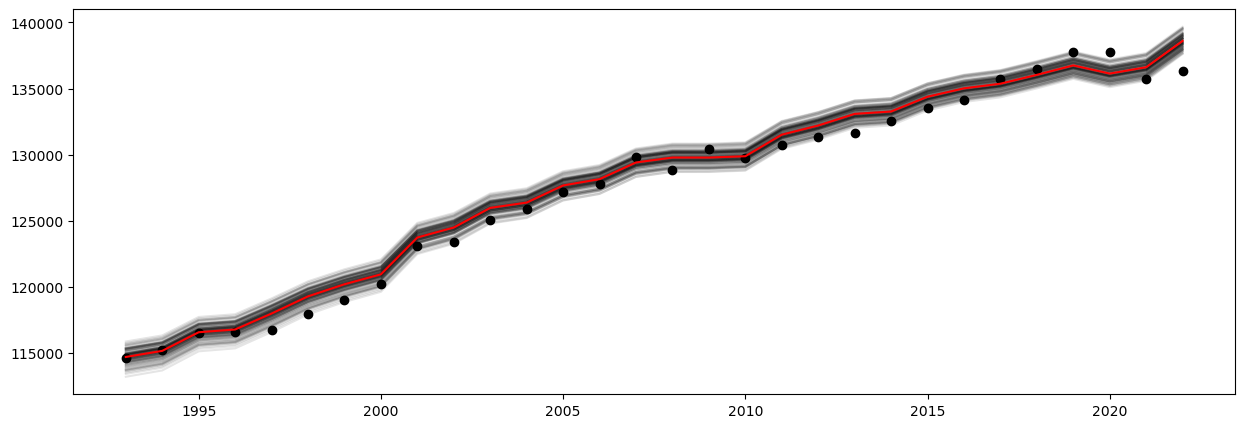

In [675]:
plt.figure(figsize=(15,5))

df_all = df_whole
for i in range(len(post_test_2.y_sim)):
    plt.plot(df_all['Year'], post_test_2.alpha_1[i]*df_all['Income per member'] + post_test_2.alpha_2[i]*df_all['Household'] - post_test_2.alpha_3[i]*df_all['Mean age'] + post_test_2.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_2.alpha_1.mean()*df_all['Income per member'] + post_test_2.alpha_2.mean()*df_all['Household'] - post_test_2.alpha_3.mean()*df_all['Mean age'] + post_test_2.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()